# PetFinder.my Pawpularity Score

In this notebook, We are using CNN+Regression architecture to predict the Pawpularity Score.

* For CNN, we are using Vision Transformer Model with MixUp augmentation.
* For Regression, we are using simple multi-layer regression model.

## Import the required Libaries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
# from keras.applications import imagenet_utils
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings("ignore")

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

## Visualize the data

In [2]:
tabular_train_data_path = '../input/petfinder-pawpularity-score/train.csv'
tabular_test_data_path = '../input/petfinder-pawpularity-score/test.csv'
base_path = '../input/petfinder-pawpularity-score'

In [3]:
train_df = pd.read_csv(tabular_train_data_path)
train_df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [4]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
train_df.isna().sum()

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64

In [6]:
train_df['path'] = base_path + '/train/' + train_df['Id'] + '.jpg'

train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


In [7]:
train_split = int(len(train_df) * 0.8) + 1
train_set = train_df[:train_split]
valid_set = train_df[train_split:]

In [8]:
train_set.tail()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
7925,cd50013762287d0237173e34fb308fe6,0,1,1,1,0,0,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/cd5...
7926,cd585fda7c298e713c950295676dfb4c,0,1,1,1,0,0,0,0,1,1,0,0,41,../input/petfinder-pawpularity-score/train/cd5...
7927,cd6ff75a03556292a604c449f863b02e,0,1,1,1,0,0,0,0,0,0,0,0,47,../input/petfinder-pawpularity-score/train/cd6...
7928,cd79beef618139277aadebc7a3f2882a,0,1,1,1,0,0,0,0,1,1,0,0,44,../input/petfinder-pawpularity-score/train/cd7...
7929,cd7b87cd2935fa9fde63f77f06d9b953,0,1,1,1,0,1,0,0,0,0,0,0,71,../input/petfinder-pawpularity-score/train/cd7...


In [9]:
valid_set.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
7930,cd863f5c6a56232e5d7b9f26656e479f,0,1,1,1,0,0,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/cd8...
7931,cd895e70682ed5151a1a411f1e656a6b,0,1,1,1,0,0,0,0,1,1,0,0,68,../input/petfinder-pawpularity-score/train/cd8...
7932,cd89974266e5591b36eb35d301d8a314,0,1,1,1,0,1,0,0,0,0,0,0,37,../input/petfinder-pawpularity-score/train/cd8...
7933,cd909abf8f425d7e646eebe4d3bf4769,0,0,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/cd9...
7934,cd969c18c37e989972b63cf5ba2455f9,0,1,1,0,0,0,0,0,1,0,0,0,35,../input/petfinder-pawpularity-score/train/cd9...


## Make the dataset

In [10]:
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance

### Image Dataset

In [11]:
def make_dataset(path, batch_size):
    
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [260, 260])
        image = image / 255.
        return image
    
    def configure_for_performance(ds):
        ds = ds.batch(batch_size)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds
    
#     filenames = glob(path)
    
    filename_ds = tf.data.Dataset.from_tensor_slices(path)
    image_ds = filename_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = configure_for_performance(image_ds)
    return ds

In [12]:
train_image_path = train_set['path'].to_list()
valid_image_path = valid_set['path'].to_list()
len(train_image_path), len(valid_image_path)

(7930, 1982)

In [13]:
batch_size = 64
train_img_ds = make_dataset(train_image_path, batch_size)
valid_img_ds = make_dataset(valid_image_path, batch_size)
train_img_ds, valid_img_ds

2022-01-12 04:13:22.102847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 04:13:22.236573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 04:13:22.237322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 04:13:22.239993: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(<PrefetchDataset shapes: (None, 260, 260, 3), types: tf.float32>,
 <PrefetchDataset shapes: (None, 260, 260, 3), types: tf.float32>)

In [14]:
train_ds_one = make_dataset(train_image_path, batch_size)

train_ds_two = make_dataset(train_image_path, batch_size)

train_ds_one, train_ds_two

(<PrefetchDataset shapes: (None, 260, 260, 3), types: tf.float32>,
 <PrefetchDataset shapes: (None, 260, 260, 3), types: tf.float32>)

In [15]:
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
train_ds

<ZipDataset shapes: ((None, 260, 260, 3), (None, 260, 260, 3)), types: (tf.float32, tf.float32)>

### Tabular dataset

In [16]:
train_table_input = train_set.iloc[:, 1:-2]
train_table_input.head(2)

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,0,1,1,1,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0


In [17]:
train_target = train_set.iloc[:, -2]
train_target.head(2)

0    63
1    42
Name: Pawpularity, dtype: int64

In [18]:
valid_table_input = valid_set.iloc[:, 1:-2]
valid_target = valid_set.iloc[:, -2]

In [19]:
len(train_set), len(valid_set)

(7930, 1982)

In [20]:
train_table_input = train_table_input.to_numpy()
train_target = train_target.to_numpy()

valid_table_input = valid_table_input.to_numpy()
valid_target = valid_target.to_numpy()

train_table_input_data = tf.data.Dataset.from_tensor_slices(train_table_input)
train_table_target_data = tf.data.Dataset.from_tensor_slices(train_target)

valid_table_input_data = tf.data.Dataset.from_tensor_slices(valid_table_input)
valid_table_target_data = tf.data.Dataset.from_tensor_slices(valid_target)


train_table_ex_data = train_table_input_data.batch(batch_size).prefetch(AUTO)
train_target_ex = train_table_target_data.batch(batch_size).prefetch(AUTO)

valid_table_ex_data = valid_table_input_data.batch(batch_size).prefetch(AUTO)
valid_target_ex = valid_table_target_data.batch(batch_size).prefetch(AUTO)




## Defining MixUp technique

In [21]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

def mix_up(ds_one, ds_two, alpha=0.2):
    # unpack dataset
    image_one = ds_one
    image_two = ds_two
    batch_size = tf.shape(image_one)[0]
    
    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    # y_l = tf.reshape(l, (batch_size, 1))          # Note needed for regression task
    
    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = image_one * x_l + image_two * (1 - x_l)
    # labels = labels_one * y_l + labels_two * (1 - y_l)            # Uncomment if have labels
    return images

### Visualize the new augmented dataset

2022-01-12 04:13:25.833294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


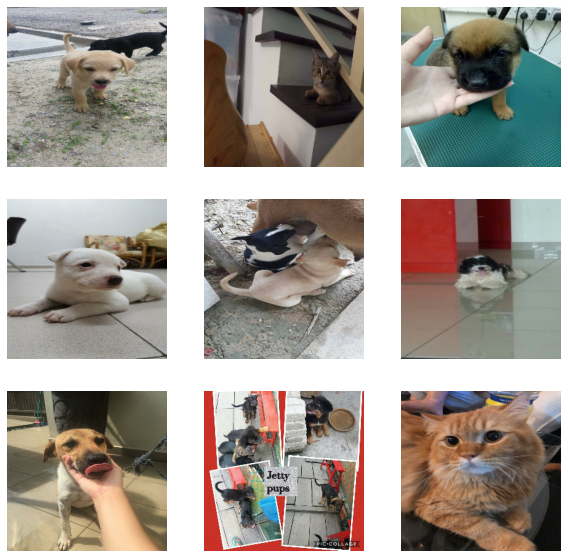

In [22]:
# First create the new dataset using out `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis(False);

In [23]:
for image in train_ds_mu.take(1):
    print("Image Size: ", image.shape)
    print("Image max val: ", tf.reduce_max(image))
    print("Image min val: ", tf.reduce_min(image))
    break

Image Size:  (64, 260, 260, 3)
Image max val:  tf.Tensor(1.0, shape=(), dtype=float32)
Image min val:  tf.Tensor(0.0, shape=(), dtype=float32)


### Making Final Dataset With MixUP

In [24]:
train_input_data = tf.data.Dataset.zip((train_img_ds, train_table_ex_data))
train_data = tf.data.Dataset.zip((train_input_data, train_target_ex))

valid_input_data = tf.data.Dataset.zip((valid_img_ds, valid_table_ex_data))
valid_data = tf.data.Dataset.zip((valid_input_data, valid_target_ex))


# train_data = tf.data.Dataset.zip((train_img_ds, train_target_ex))

# valid_data = tf.data.Dataset.zip((valid_img_ds, valid_target_ex))

train_data, valid_data

(<ZipDataset shapes: (((None, 260, 260, 3), (None, 12)), (None,)), types: ((tf.float32, tf.int64), tf.int64)>,
 <ZipDataset shapes: (((None, 260, 260, 3), (None, 12)), (None,)), types: ((tf.float32, tf.int64), tf.int64)>)

In [25]:
bit_model_path = '../input/bitmr101'
bit_module = hub.KerasLayer(bit_model_path)

# nlp_model_path = '../input/mobilebert-m1'
# nlp_module = hub.KerasLayer(nlp_model_path)

# image model
img_inputs = tf.keras.layers.Input(shape=(260, 260, 3), name='img_input')
base_model = bit_module(img_inputs)

# drp_out1 = tf.keras.layers.Dropout(0.4)(base_model)
img_outputs = tf.keras.layers.Dense(128, activation='relu')(base_model)
# batch_1= tf.keras.layers.BatchNormalization()(img_outputs)
drp_out2 = tf.keras.layers.Dropout(0.25)(img_outputs)
# fc1 = tf.keras.layers.Dense(64, activation='relu')(batch_1)
# fc2 = tf.keras.layers.Dense(32, activation='relu')(fc1)
img_out = tf.keras.layers.Dense(12, activation='relu')(drp_out2)


# tab_inputs = tf.keras.layers.Input(shape=(128), name='tab_input')
# base_model_2 = nlp_module(tab_inputs)

tab_inputs = tf.keras.Input(shape=(12,), name='tab_input')
tab_dense = tf.keras.layers.Dense(256, activation='relu')(tab_inputs)
# batch_1= tf.keras.layers.BatchNormalization()(tab_dense)
# fc1 = tf.keras.layers.Dense(256, activation='relu')(batch_1)
drp_out3 = tf.keras.layers.Dropout(0.25)(tab_dense)
fc2 = tf.keras.layers.Dense(256, activation='relu')(drp_out3)
drp_out4 = tf.keras.layers.Dropout(0.25)(fc2)
tab_fc = tf.keras.layers.Dense(12,activation='relu')(drp_out4)

# tab_fc = tf.keras.layers.Dense(12,activation='relu')(base_model_2)

max_out = tf.keras.layers.add([img_out, tab_fc])

# max_dense_1 = tf.keras.layers.Dense(128, activation='relu')(max_out)
# # batch_2= tf.keras.layers.BatchNormalization()(max_dense_1)
# max_dense_2 = tf.keras.layers.Dense(128, activation='relu')(batch_2)
# drp_out5= tf.keras.layers.Dropout(0.25)(max_dense_2)
# max_dense_3 = tf.keras.layers.Dense(128, activation='relu')(drp_out5)
# drp_out6 = tf.keras.layers.Dropout(0.25)(max_dense_3)

# max_dense_4 = tf.keras.layers.Dense(12)(drp_out6)
out = tf.keras.layers.Dense(1)(max_out)

model = tf.keras.Model(inputs=[img_inputs, tab_inputs], outputs=out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tab_input (InputLayer)          [(None, 12)]         0                                            
__________________________________________________________________________________________________
img_input (InputLayer)          [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          3328        tab_input[0][0]                  
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 2048)         42492480    img_input[0][0]                  
______________________________________________________________________________________________

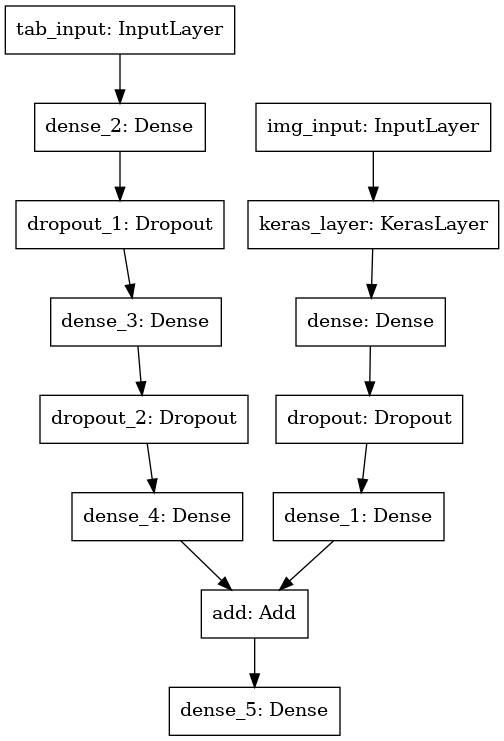

In [26]:
tf.keras.utils.plot_model(model, "model.png")

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,mode = 'auto',verbose=1) 

In [28]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(train_data, epochs=4, validation_data=valid_data,callbacks = [callback])

Epoch 1/4


2022-01-12 04:14:33.351917: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


124/124 [==============================] - 121s 740ms/step - loss: 415.7937 - root_mean_squared_error: 20.3910 - val_loss: 357.5620 - val_root_mean_squared_error: 18.9093
Epoch 2/4
124/124 [==============================] - 88s 712ms/step - loss: 349.8600 - root_mean_squared_error: 18.7045 - val_loss: 332.0516 - val_root_mean_squared_error: 18.2223
Epoch 3/4
124/124 [==============================] - 88s 710ms/step - loss: 340.3589 - root_mean_squared_error: 18.4488 - val_loss: 334.2533 - val_root_mean_squared_error: 18.2826
Epoch 00003: early stopping


In [29]:
# bit_model_path = '../input/bitmr50x1'
# bit_module = hub.KerasLayer(bit_model_path)

# # image model
# img_inputs = tf.keras.layers.Input(shape=(260, 260, 3), name='img_input')
# base_model = bit_module(img_inputs)

# # drp_out1 = tf.keras.layers.Dropout(0.4)(base_model)
# img_outputs = tf.keras.layers.Dense(128, activation='relu')(base_model)
# # batch_1= tf.keras.layers.BatchNormalization()(img_outputs)

# # fc1 = tf.keras.layers.Dense(64, activation='relu')(batch_1)
# # fc2 = tf.keras.layers.Dense(32, activation='relu')(fc1)
# # drp_out2 = tf.keras.layers.Dropout(0.4)(fc2)
# img_out = tf.keras.layers.Dense(12, activation='relu')(img_outputs)

# tab_inputs = tf.keras.Input(shape=(12,), name='tab_input')
# tab_dense = tf.keras.layers.Dense(128, activation='relu')(tab_inputs)
# batch_1= tf.keras.layers.BatchNormalization()(tab_dense)
# fc1 = tf.keras.layers.Dense(64, activation='relu')(batch_1)
# fc2 = tf.keras.layers.Dense(32, activation='relu')(fc1)
# drp_out2 = tf.keras.layers.Dropout(0.4)(fc2)
# tab_fc = tf.keras.layers.Dense(12)(drp_out2)


# max_out = tf.keras.layers.add([img_out, tab_fc])
# out = tf.keras.layers.Dense(1)(max_out)
# model = tf.keras.Model(inputs=[img_inputs, tab_inputs], outputs=out)

# model.summary()

In [30]:
# model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                           optimizer=tf.keras.optimizers.Adam(),
#                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
# # # 

# history = model.fit(train_data, epochs=10, validation_data=valid_data,callbacks = [Earlystopping])

In [31]:
# bit_model_path = '../input/bitmr101'
# bit_module = hub.KerasLayer(bit_model_path)


# # image model
# img_inputs = tf.keras.layers.Input(shape=(260, 260, 3), name='img_input')
# base_model = bit_module(img_inputs)

# # drp_out1 = tf.keras.layers.Dropout(0.4)(base_model)
# img_outputs = tf.keras.layers.Dense(128, activation='relu')(base_model)
# # batch_1= tf.keras.layers.BatchNormalization()(img_outputs)

# # fc1 = tf.keras.layers.Dense(64, activation='relu')(batch_1)
# # fc2 = tf.keras.layers.Dense(32, activation='relu')(fc1)
# # drp_out2 = tf.keras.layers.Dropout(0.4)(fc2)
# img_out = tf.keras.layers.Dense(12, activation='relu')(img_outputs)

# tab_inputs = tf.keras.Input(shape=(12,), name='tab_input')
# tab_dense = tf.keras.layers.Dense(128, activation='relu')(tab_inputs)
# batch_1= tf.keras.layers.BatchNormalization()(tab_dense)
# fc1 = tf.keras.layers.Dense(64, activation='relu')(batch_1)
# fc2 = tf.keras.layers.Dense(32, activation='relu')(fc1)
# drp_out2 = tf.keras.layers.Dropout(0.4)(fc2)
# tab_fc = tf.keras.layers.Dense(12)(drp_out2)


# max_out = tf.keras.layers.add([img_out, tab_fc])
# out = tf.keras.layers.Dense(1)(max_out)
# model = tf.keras.Model(inputs=[img_inputs, tab_inputs], outputs=out)

# model.summary()

In [32]:
# Earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_', patience=1) 

In [33]:
# model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                           optimizer=tf.keras.optimizers.Adam(),
#                           metrics=[tf.keras.metrics.RootMeanSquaredError()])
# # # 

# history = model.fit(train_data, epochs=6, validation_data=valid_data,callbacks = [Earlystopping])

## Visualize The Loss 

In [34]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, rmse, label='train_rmse')
    plt.plot(epochs, val_rmse, label='val_rmse')
    plt.title('RMSE')
    plt.xlabel('Epochs')
    plt.legend();

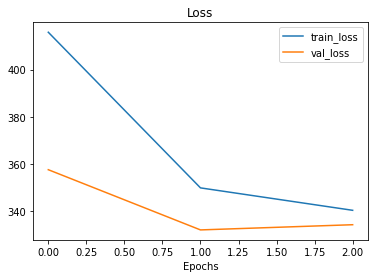

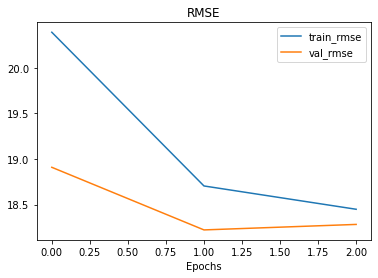

In [35]:
plot_loss_curves(history)

## Make Prediction on Test set

In [36]:
test_df = pd.read_csv(tabular_test_data_path)
test_df.head(10)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


In [37]:
test_dir = base_path + '/test/'

In [38]:
test_input = test_df.iloc[:, 1:]
test_input.head(10)

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,1,0,1,0,0,1,1,0,0,1,0,1
1,0,1,0,0,0,0,1,1,0,0,0,0
2,0,0,0,1,0,1,1,1,0,1,1,1
3,1,0,1,0,0,0,0,0,0,0,1,0
4,1,1,1,0,1,1,0,1,0,1,1,0
5,0,0,1,1,1,1,1,1,1,0,1,0
6,1,0,0,0,1,1,0,1,0,1,1,1
7,1,0,1,0,0,0,0,0,1,0,0,1


In [39]:
test_input = test_input.to_numpy()

In [40]:
test_input[0]

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [41]:
img = test_dir + test_df['Id'][0] + '.jpg'
img

'../input/petfinder-pawpularity-score/test/4128bae22183829d2b5fea10effdb0c3.jpg'

In [42]:
def preprocess_test(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image, channels=3)
    image = tf.image.resize(image, (260, 260))
#     image = image / 255.0
    return image

In [43]:
image0 = preprocess_test(img)
tf.expand_dims(image0, axis=0).shape

TensorShape([1, 260, 260, 3])

In [44]:
y_pred = model.predict((tf.expand_dims(image0, axis=0), tf.expand_dims(test_input[0], axis=0)))

In [45]:
y_pred

array([[40.503223]], dtype=float32)

In [46]:
y_pred[0].item()

40.50322341918945

In [47]:
Pawpularity = []
for i in range(len(test_df)):
    img = test_dir + test_df['Id'][i] + '.jpg'
    image = preprocess_test(img)
    y_pred = model.predict([tf.expand_dims(image, axis=0), tf.expand_dims(test_input[i], axis=0)])
    
    Pawpularity.append(y_pred[0].item())
    
Pawpularity

[40.50322341918945,
 43.464778900146484,
 42.30852508544922,
 37.18910598754883,
 41.220577239990234,
 43.47724533081055,
 36.81096267700195,
 38.261680603027344]

In [48]:
sub = {
    'id' : test_df.Id,
    'Pawpularity' : Pawpularity
}

sub_df = pd.DataFrame(sub)
sub_df

,id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.503223
1,43a2262d7738e3d420d453815151079e,43.464779
2,4e429cead1848a298432a0acad014c9d,42.308525
3,80bc3ccafcc51b66303c2c263aa38486,37.189106
4,8f49844c382931444e68dffbe20228f4,41.220577
5,b03f7041962238a7c9d6537e22f9b017,43.477245
6,c978013571258ed6d4637f6e8cc9d6a3,36.810963
7,e0de453c1bffc20c22b072b34b54e50f,38.261681


In [49]:
sub_df.to_csv('submission.csv', index=False)